In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import random
import warnings
warnings.filterwarnings("ignore")

# Feature scaling most of the times increases the performance
from sklearn.preprocessing import MinMaxScaler


# Deep learning packages
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
fundamentals = pd.read_csv('/content/drive/My Drive/AsknBid Challenge/fundamentals.csv')
prices_adj = pd.read_csv('/content/drive/My Drive/AsknBid Challenge/prices-split-adjusted.csv')
prices = pd.read_csv('/content/drive/My Drive/AsknBid Challenge/prices.csv')
comp_info = pd.read_csv('/content/drive/My Drive/AsknBid Challenge/securities.csv')

In [4]:
print(prices_adj.shape)
prices_adj.head()

(851264, 7)


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
prices_adj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [6]:
prices_adj.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


# Helper Functions

In [0]:
def plot_price_volume(df, symbol):
  plt.figure(figsize=(10, 50));
  plt.subplot(5,1,1);
  plt.plot(df[df.symbol == symbol].open.values, color='red', label='open')
  plt.title('stock price')
  plt.xlabel('time [days]')
  plt.ylabel('price')
  plt.legend(loc='best')
  plt.subplot(5,1,2);
  plt.plot(df[df.symbol == symbol].close.values, color='green', label='close')
  plt.title('stock price')
  plt.xlabel('time [days]')
  plt.ylabel('price')
  plt.legend(loc='best')
  plt.subplot(5,1,3);
  plt.plot(df[df.symbol == symbol].low.values, color='blue', label='low')
  plt.title('stock price')
  plt.xlabel('time [days]')
  plt.ylabel('price')
  plt.legend(loc='best')

  plt.subplot(5,1,4);
  plt.plot(df[df.symbol == symbol].high.values, color='black', label='high')
  plt.title('stock price')
  plt.xlabel('time [days]')
  plt.ylabel('price')
  plt.legend(loc='best')
  #plt.show()

  plt.subplot(5,1,5);
  plt.plot(df[df.symbol == symbol].volume.values, color='black', label='volume')
  plt.title('stock volume')
  plt.xlabel('time [days]')
  plt.ylabel('volume')
  plt.legend(loc='best')
  plt.show()

In [0]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    # df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    # df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df, min_max_scaler # To inverse transform the results we get from RNN

In [0]:
def prepare_data(stock, seq_len, valid_size = 0.1, test_size = 0.1):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_size*data.shape[0]));  
    test_set_size = int(np.round(test_size*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# Modelling

In [10]:
df = prices_adj.copy() # Take the prices adjusted dataset to build model.

# number of different stocks
print('\nnumber of different stocks(companies): ', len(list(set(df.symbol))))
print("Few of them are below : \n",list(set(df.symbol))[:10])


number of different stocks(companies):  501
Few of them are below : 
 ['TJX', 'M', 'PSA', 'WDC', 'CAH', 'HPQ', 'HSIC', 'FB', 'FTI', 'FOX']


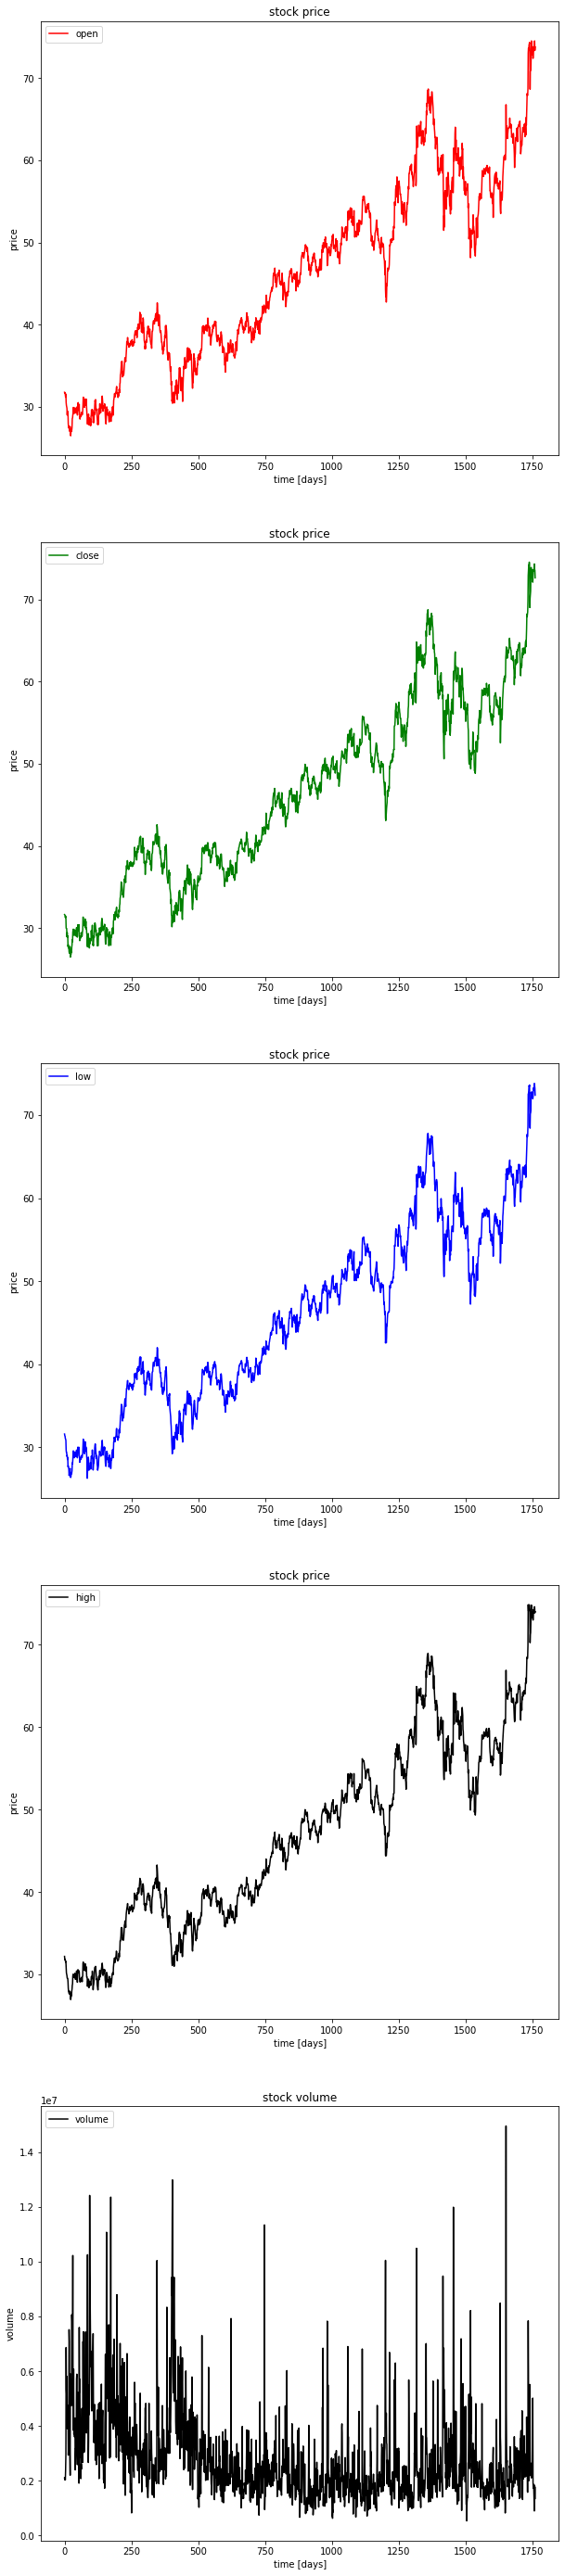

In [11]:
plot_price_volume(df, symbol = 'ADI')

# Stock Price Prediction for particular stock
1. Choose a stock of your choice
2. Normalize stock data for better performance
3. Create time series split to get train and validation splits
4. Performace Evaluation
5. Stock Price prediction of Tomorrow .

In [12]:
# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol','volume','date','low','high','open'],1,inplace=True) # Note we can predict any of them

cols = list(df_stock.columns.values)
print(cols)

['close']


In [16]:
# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm, scaler = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
X_train, y_train, X_valid, y_valid, X_test, y_test = prepare_data(df_stock_norm, seq_len)

# X_train = X_train.reshape(1394,19)
# X_valid = X_valid.reshape(174,19)
# X_test = X_test.reshape(174,19)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_valid.shape = ',X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (1394, 19, 1)
y_train.shape =  (1394, 1)
X_valid.shape =  (174, 19, 1)
y_valid.shape =  (174, 1)
X_test.shape =  (174, 19, 1)
y_test.shape =  (174, 1)


# RNN Model

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      (None, 19, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


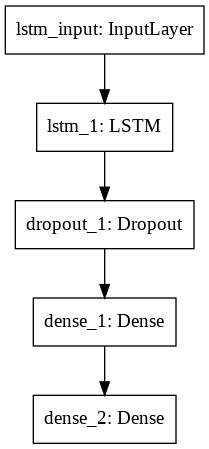

In [17]:
np.random.seed(4)

lookback = 19
lookahead = 5

lstm_input = Input(shape=(lookback, 1), name='lstm_input')
x = LSTM(units=64, return_sequences=False, return_state=False)(lstm_input)  
x = Dropout(0.2)(x)
x = Dense(units=32, activation='relu')(x)
output = Dense(1, activation='linear')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

weights = model.get_weights()  # needed to reset the model 

model.summary()
from keras.utils import plot_model
plot_model(model)

In [18]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid,y_valid),verbose=1)

Train on 1394 samples, validate on 174 samples
Epoch 1/100
1394/1394 [==============================] - 1s 636us/step - loss: 0.0145 - val_loss: 0.0047
Epoch 2/100
1394/1394 [==============================] - 1s 378us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/100
1394/1394 [==============================] - 1s 373us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/100
1394/1394 [==============================] - 1s 363us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/100
1394/1394 [==============================] - 1s 406us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/100
1394/1394 [==============================] - 1s 416us/step - loss: 8.8078e-04 - val_loss: 0.0012
Epoch 7/100
1394/1394 [==============================] - 1s 368us/step - loss: 8.3789e-04 - val_loss: 0.0016
Epoch 8/100
1394/1394 [==============================] - 1s 362us/step - loss: 8.3953e-04 - val_loss: 8.9085e-04
Epoch 9/100
1394/1394 [==============================] - 1s 397us/step - loss: 8.0178e-04 - val_l

In [19]:
from sklearn.metrics import mean_squared_error
print("Train RMSE : ", np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
print("Valid RMSE : ", np.sqrt(mean_squared_error(y_valid, model.predict(X_valid))))
print("Test RMSE : ", np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

Train RMSE :  0.013687504669117162
Valid RMSE :  0.02891080409976972
Test RMSE :  0.02683294240450752


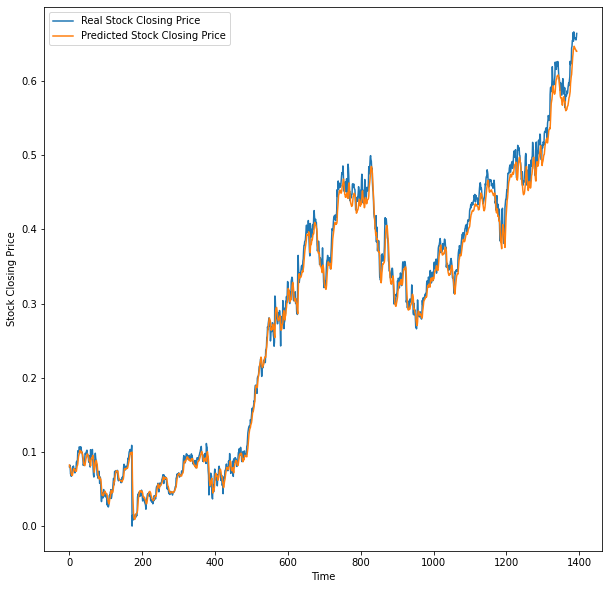

In [22]:
plt.figure(figsize=(10,10))
plt.plot(range(len(y_train)),y_train, label = 'Real Stock Closing Price')
plt.plot(range(len(y_train)), model.predict(X_train), label = 'Predicted Stock Closing Price')
plt.xlabel('Time')
plt.ylabel('Stock Closing Price')
plt.legend()
plt.show()

# Final results

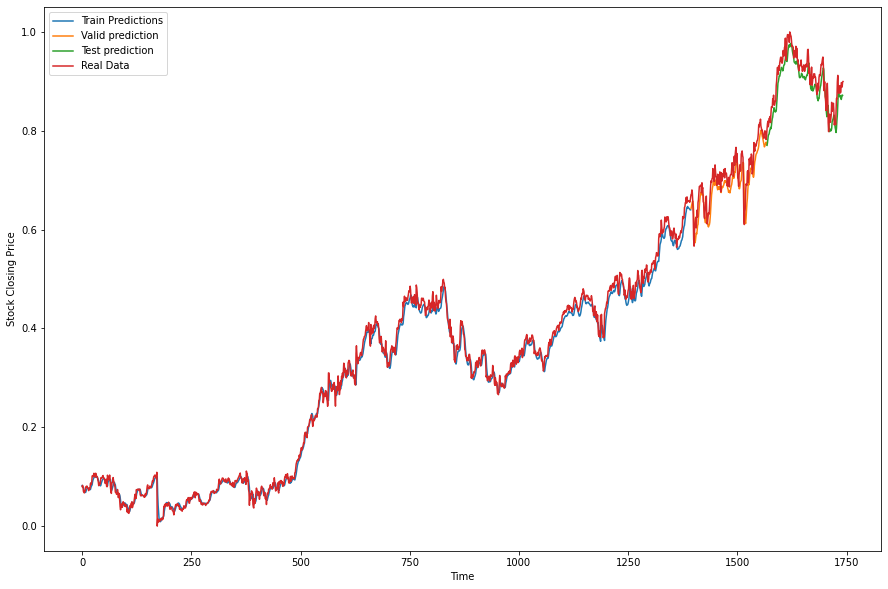

In [24]:
plt.figure(figsize=(15,10))
plt.plot(range(len(y_train)),model.predict(X_train), label = 'Train Predictions')
plt.plot(range(len(y_train), len(y_train) + len(y_valid)), model.predict(X_valid), label = 'Valid prediction')
plt.plot(range(len(y_train) + len(y_valid),len(y_test) + len(y_valid) + len(y_train)), model.predict(X_test), label = 'Test prediction')
plt.plot(range(len(df_stock) - 19),df_stock_norm[19:],label = 'Real Data')
plt.xlabel('Time')
plt.ylabel('Stock Closing Price')
plt.legend()
plt.show()

# Stock Closing Price of Tomorrow

In [33]:
data = df_stock_norm[-19:].values.reshape(1,19,1) # Past 19 days closing price.
print("Stock Closing price for tomorrow can be : {}$".format(scaler.inverse_transform(model.predict(data))[0][0]))

Stock Closing price for tomorrow can be : 350.3936462402344$


# Final Comments
1. In the above, we build a RNN model for predictiong the stock closing price of a particular stock, results are quite promising as well compared to complexity of model.
2. In the same way we can find for Open, high, close of stock price using similar procedure.
3. In the above model, I had performed hyper-parameter tuning only for learning rate as well number of past data points to be considered to predict for today. There are few more hyper-parameters we can tune like number of epoch, thresholding validation loss change,  batch size, different optimizer.
4. Remember we built a RNN aka deep learning model, we can also convert this problem statement to a stationary model and then predict using machine learning models like LGBM, XGB and ANN.
5. I had built a simple lgbm model for this dataset but the results are not close to the RNN results above.(Remember technical indicators can be used to improve the LGBM model)

5. Further improvements, if I had given a task to improve this model using extra features, then I might change this model to Stationary model and then add the extra techincal indicators as extra feature and fit a robust lgbm model and finalize the closing price by ensemble of LGBM and RNN model.


# Thank you for this challenge.